In [49]:
import pandas as pd
from typing import List
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    cohen_kappa_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [50]:
path_to_gpt_annotations_database = "./data/llm_annotations.csv"
path_to_human_annotations_database = "./data/human_annotations.csv"
path_to_dis_agreements_between_humans = "./outputs/human_expert_disagreements_to_annotate.csv"

# Utils & Settings

In [51]:
single_option_resp_by_qID = {"Type", "HeadAcc1", "LedePres", "ArtBias", "SensLang", "NegTarg1"}
multi_option_resp_by_qID = {"NegTarg2"}
all_resp_qIDs = single_option_resp_by_qID.union(multi_option_resp_by_qID)

responses_by_qID:dict = {
    "Type" : {1 : "Notizia di cronaca, attualita’, notizia che riguarda il paese o notizia internazionale", 2 : "Editoriale o opinione", 3 : "Inchiesta", 4 : "Satira", 5 : "Notizia di costume o cronaca rosa"},
    "HeadAcc1" : {1 : "Non accurato", 2 : "Abbastanza inaccurato", 3 : "Abbastanza accurato", 4 : "Accurato"},
    "LedePres" : {1 : "No", 2 : "Si"},
    "ArtBias" : {1 : "Di parte", 2 : "Abbastanza di parte", 3 : "Abbastanza imparziale", 4 : "Imparziale"},
    "SensLang" : {1 : "Sensazionale", 2 : "Abbastanza sensazionale", 3 : "Abbastanza neutro", 4 : "Neutro"},
    "NegTarg1" : {1 : "No", 2 : "Si"},
    "NegTarg2" : {"1" : "Politica", "2" : "Gender", "3" : "Religione", "4" : "Altro"}
}


def core_get_annotations_on_common_articles_wo_criteria(f_hum, f_gpt):
  set_h_art_id:set = set(f_hum['art_id'].tolist())
  set_g_art_id:set = set(f_gpt['art_id'].tolist())

  common = set_h_art_id.intersection(set_g_art_id)

  comm_f_hum = f_hum.loc[f_hum['art_id'].isin(common)][['art_id', 'annotation']].rename(columns={"annotation": "human_annotation"})
  comm_f_gpt = f_gpt.loc[f_gpt['art_id'].isin(common)][['art_id', 'annotation']].rename(columns={"annotation": "gpt_annotation"})

  res = comm_f_hum.merge( comm_f_gpt, on='art_id', how='left')

  return res

def core_get_annotations_on_common_articles(criteria, human_annotations, gpt_annotations):
  f_hum = human_annotations.loc[human_annotations["criteriaID"] == criteria]
  f_gpt = gpt_annotations.loc[gpt_annotations["criteriaID"] == criteria]

  return core_get_annotations_on_common_articles_wo_criteria(f_hum, f_gpt)


def get_annotations_on_common_articles(criteria, human_annotations, gpt_annotations):
  res = core_get_annotations_on_common_articles(criteria, human_annotations, gpt_annotations)
  if criteria in multi_option_resp_by_qID:
    res['human_annotation'] = res['human_annotation'].apply(lambda x: x)
    res['gpt_annotation'] = res['gpt_annotation'].apply(lambda x: x)
  else:
    res['human_annotation'] = res['human_annotation'].apply(lambda x: int(float(x)))
    res['gpt_annotation'] = res['gpt_annotation'].apply(lambda x: int(float(x)))
  return res

def filtering_agreements_between_humans_not_with_LLM(criteria, hum_df, gpt_df):
  res = get_annotations_on_common_articles(criteria, hum_df, gpt_df)
  #consider only when gpt disagrees
  res = res.loc[res['human_annotation'] != res['gpt_annotation']]
  return res

def filtering_human_annotations_in_disagreement(criteria, hum_df, gpt_df):
  return get_annotations_on_common_articles(criteria, hum_df, gpt_df)

def compact_human_annotations_in_single_line( df ):

  group_cols = ['art_id', 'gpt_annotation', 'expost_groundtruth',
              'criteriaID', 'gpt_annotation_verbose']

  def merge_rows(group):
    if len(group) == 2:  # We assume a maximum of 2 matching rows
        group['human_annotation2'] = group['human_annotation'].iloc[1]
        group['human_annotation2_verbose'] = group['human_annotation_verbose'].iloc[1]
    else:  # If there is not two matching rows we leave empty fields
        group['human_annotation2'] = None
        group['human_annotation2_verbose'] = None
    return group

  df_grouped = df.groupby(group_cols, group_keys=False).apply(merge_rows)

  df_final = df_grouped.drop_duplicates(subset=group_cols).reset_index(drop=True)

  return df_final


def compute_disagreements_manual_annotation(hum_df, gpt_df, filtering):

  future_insert_total = []
  for c in all_resp_qIDs:

    res = filtering(c, hum_df, gpt_df)

    res["expost_groundtruth"] = "Empty"
    res["criteriaID"] = c
    res["human_annotation_verbose"] = None
    res["gpt_annotation_verbose"] = None

    if c not in multi_option_resp_by_qID:
      res["human_annotation_verbose"] = res['human_annotation'].apply(lambda x: responses_by_qID[c][x])
      res["gpt_annotation_verbose"] = res['gpt_annotation'].apply(lambda x: responses_by_qID[c][x])
    else :
      #In order to help annotation I put all possible responses
      res["human_annotation_verbose"] = res['human_annotation'].apply(lambda x: str(responses_by_qID[c]))
      res["gpt_annotation_verbose"] = res['gpt_annotation'].apply(lambda x: str(responses_by_qID[c]))

    res = compact_human_annotations_in_single_line(res)

    res = res.dropna(subset=["human_annotation",	"human_annotation2"])

    res = res.sort_values(by=['art_id'])
    res["borderline"] = "Empty"
    res["to_annotate"] = True
    if c not in multi_option_resp_by_qID:
      def is_hum_annotation_different_enought_or_special_criteria(c, h_a_1, h_a_2):
        if c in ["LedePres", "NegTarg1", "Type"]:
          return True
        return True if max(h_a_1, h_a_2) - min(h_a_1, h_a_2) > 1 else False

      res["to_annotate"] = res.apply(lambda row: is_hum_annotation_different_enought_or_special_criteria(c, row['human_annotation'], row['human_annotation2']), axis=1)

    future_insert_total.append( res[["art_id", "criteriaID","human_annotation", "human_annotation2", "gpt_annotation", "expost_groundtruth", "to_annotate", "human_annotation_verbose", "human_annotation2_verbose",	"gpt_annotation_verbose"]] )

  return pd.concat(future_insert_total)

In [52]:
gpt_annotations:pd.DataFrame = pd.read_csv(path_to_gpt_annotations_database, encoding='utf-8')
human_annotations:pd.DataFrame = pd.read_csv(path_to_human_annotations_database, encoding='utf-8')

In [53]:
gb = human_annotations[['art_id', 'criteriaID', 'annotation']].groupby(['art_id', 'criteriaID', 'annotation']).size().reset_index(name='common_annotation_count').sort_values(by=['common_annotation_count'], ascending=True)
future_insert_in_agreement = []
future_insert_in_disagreement = []

for index, row in gb.iterrows():

  if row['common_annotation_count'] >= 2:
    future_insert_in_agreement.append(
        human_annotations.loc[ (human_annotations['art_id'] == row['art_id']) & (human_annotations['criteriaID'] == row['criteriaID']) & (human_annotations['annotation'] == row['annotation'])].head(1)
    )

  elif row['common_annotation_count'] == 1:
    future_insert_in_disagreement.append(
        human_annotations.loc[ (human_annotations['art_id'] == row['art_id']) & (human_annotations['criteriaID'] == row['criteriaID']) & (human_annotations['annotation'] == row['annotation'])].head(1)
    )
  else:
    print(row)
    print("-------")

#Human-experts annotators in agreement
human_annotations_in_agreement = pd.concat(future_insert_in_agreement)[['art_id', 'criteriaID', 'annotation']]

# In this dataframe, we have: 
# (i) cases where there is only one annotation, either on a criterion or on an article, 
# (ii) annotations for which the human expert annotators disagree.
human_annotations_in_disagreement = pd.concat(future_insert_in_disagreement)[['art_id', 'criteriaID', 'annotation']]

# Criteria Agreement Analysis

In [54]:
mappers_to_downscale_the_problem  = {
    "HeadAcc1" : {1 : 1, 2 : 1, 3 : 2, 4 : 2},
    "ArtBias" : {1 : 1, 2 : 1, 3 : 2, 4 : 2},
    "SensLang" : {1 : 1, 2 : 1, 3 : 2, 4 : 2}
}
future_plots_by_criteria = {}
future_insert = []

for c in single_option_resp_by_qID:

  res = get_annotations_on_common_articles(c, human_annotations_in_agreement, gpt_annotations)

  kappa = cohen_kappa_score(res['human_annotation'], res['gpt_annotation'])
  kappa_downscaled = None

  #downscaling the problem
  if c in mappers_to_downscale_the_problem:
    res['human_annotation_downscale'] = res['human_annotation'].apply(lambda x: mappers_to_downscale_the_problem[c][x])
    res['gpt_annotation_downscale'] = res['gpt_annotation'].apply(lambda x: mappers_to_downscale_the_problem[c][x])
    #res[['art_id', 'human_annotation_downscale', 'gpt_annotation_downscale']].plot(kind='hist', title=c+'_downscaled', alpha=0.5)

    kappa_downscaled = cohen_kappa_score(res['human_annotation_downscale'], res['gpt_annotation_downscale'])

  future_insert.append( {"criteriaID" : c, "Cohen_kappa" : kappa, "Cohen_kappa_downscaled" : kappa_downscaled} )
  future_plots_by_criteria[c] = res

pd.DataFrame(future_insert)

,criteriaID,Cohen_kappa,Cohen_kappa_downscaled
0,LedePres,0.403409,NaN
1,NegTarg1,0.709314,NaN
2,ArtBias,0.201665,0.475639
3,HeadAcc1,0.181719,0.075773
4,Type,0.506903,NaN
5,SensLang,0.168065,0.538510


/home/manuel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/manuel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/manuel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/manuel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

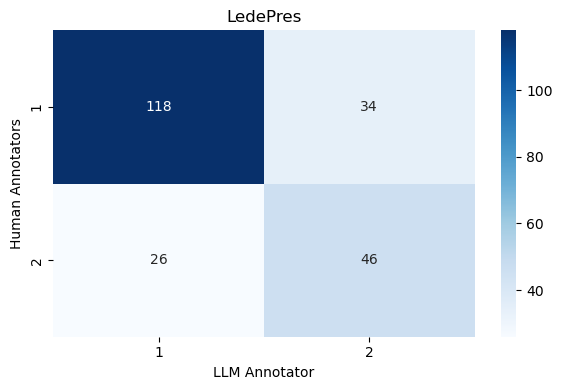

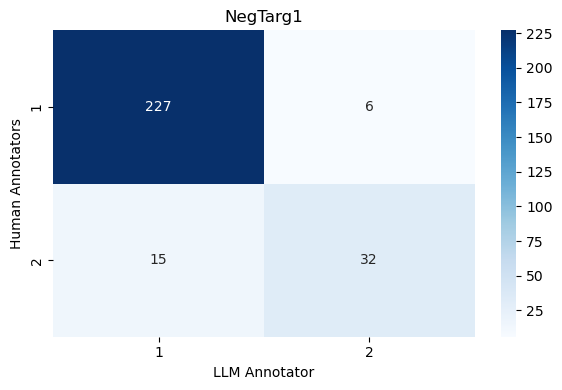

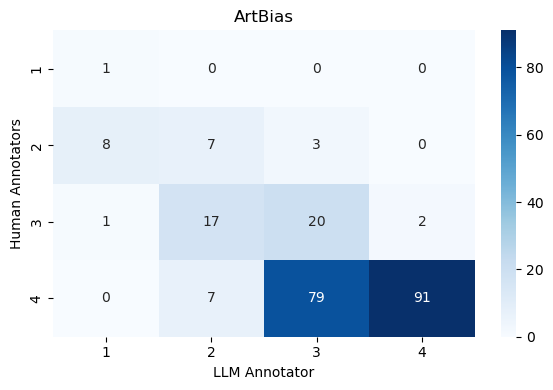

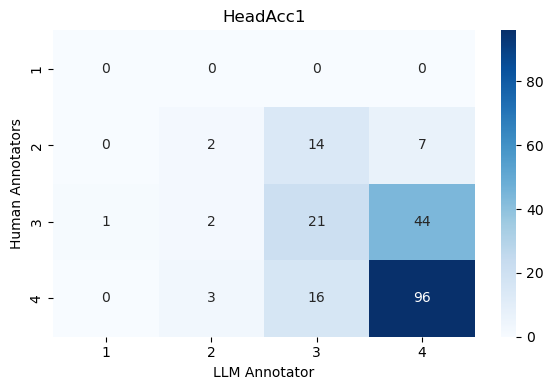

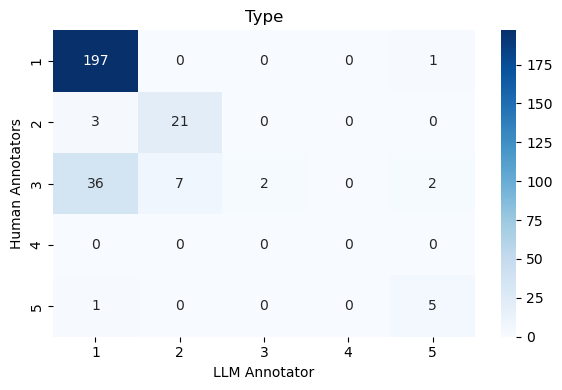

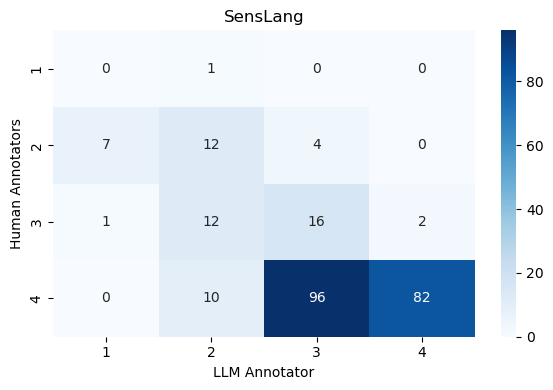

In [55]:
possible_options_by_criteria = {
    "Type" : [1, 2, 3, 4, 5],
    "HeadAcc1" : [1, 2, 3, 4],
    "LedePres" : [1, 2],
    "ArtBias" : [1, 2, 3, 4],
    "SensLang" : [1, 2, 3, 4],
    "NegTarg1" : [1, 2],
    "NegTarg2" : ["-1", "0","1", "2", "3", "4"],
    "HeadAcc2" : ["-1", "0", "1", "2", "3", "4"]
    }

future_insert_perf_metrics = []

for c in single_option_resp_by_qID:
  curr_to_plot = future_plots_by_criteria[c]

  y_true = curr_to_plot['human_annotation']
  y_pred = curr_to_plot['gpt_annotation']

  # Compute the confusion matrix
  cm = confusion_matrix(y_true, y_pred, labels=possible_options_by_criteria[c])

  future_insert_perf_metrics.append({
      "criteriaID" : c,
      "balanced_acc" : balanced_accuracy_score(y_true, y_pred),
      "f1_score" : f1_score(y_true, y_pred, average='weighted'),
      "precision" : precision_score(y_true, y_pred, average='weighted'),
      "recall" : recall_score(y_true, y_pred, average='weighted'),
      "balanced_acc_multi" : balanced_accuracy_score(y_true, y_pred),
      "precision_macro" : precision_score(y_true, y_pred, average='macro'),
      "recall_macro" : recall_score(y_true, y_pred, average='macro'),
      "f1_macro" : f1_score(y_true, y_pred, average='macro'),
  })

  if c in mappers_to_downscale_the_problem:
    y_true_ds = curr_to_plot['human_annotation_downscale']
    y_pred_ds = curr_to_plot['gpt_annotation_downscale']
    future_insert_perf_metrics.append({
      "criteriaID" : c+"_downscale",
      "balanced_acc" : balanced_accuracy_score(y_true_ds, y_pred_ds),
      "f1_score" : f1_score(y_true_ds, y_pred_ds, average='weighted'),
      "precision" : precision_score(y_true_ds, y_pred_ds, average='weighted'),
      "recall" : recall_score(y_true_ds, y_pred_ds, average='weighted'),
      "balanced_acc_multi" : balanced_accuracy_score(y_true_ds, y_pred_ds),
      "precision_macro" : precision_score(y_true_ds, y_pred_ds, average='macro'),
      "recall_macro" : recall_score(y_true_ds, y_pred_ds, average='macro'),
      "f1_macro" : f1_score(y_true_ds, y_pred_ds, average='macro'),
  })


  # Create a heatmap
  plt.figure(figsize=(6,4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=possible_options_by_criteria[c], yticklabels=possible_options_by_criteria[c])
  plt.xlabel('LLM Annotator')
  plt.ylabel('Human Annotators')
  plt.title( c )
  plt.tight_layout()
  plt.savefig("./outputs/cmatrix_"+c, dpi=300, bbox_inches='tight')


In [56]:
pd.DataFrame(future_insert_perf_metrics)

,criteriaID,balanced_acc,f1_score,precision,recall,balanced_acc_multi,precision_macro,recall_macro,f1_macro
0,LedePres,0.707602,0.735572,0.740873,0.732143,0.707602,0.697222,0.707602,0.701280
1,NegTarg1,0.827550,0.921740,0.921917,0.925000,0.827550,0.890061,0.827550,0.854365
2,ArtBias,0.600753,0.575862,0.784751,0.504237,0.600753,0.375095,0.600753,0.355824
3,ArtBias_downscale,0.863449,0.899940,0.936763,0.881356,0.863449,0.687430,0.863449,0.732686
4,HeadAcc1,0.410188,0.540493,0.532395,0.577670,0.410188,0.337635,0.307641,0.304775
5,HeadAcc1_downscale,0.527085,0.839802,0.822043,0.868932,0.527085,0.571970,0.527085,0.529083
6,Type,0.686459,0.752164,0.848481,0.818182,0.686459,0.801556,0.686459,0.627339
7,SensLang,0.368510,0.533409,0.805290,0.452675,0.368510,0.364245,0.368510,0.308605
8,SensLang_downscale,0.864155,0.902124,0.929147,0.888889,0.864155,0.722558,0.864155,0.766288


-------NegTarg2--------


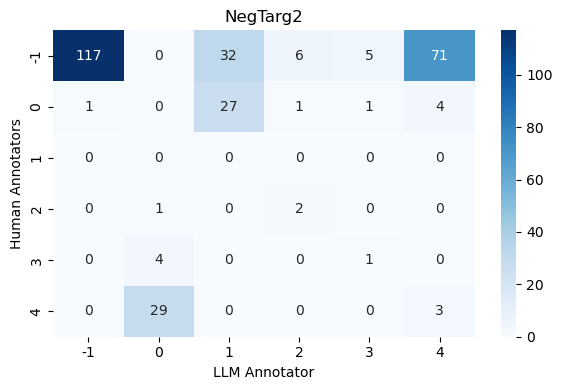

In [57]:

def get_max_lenght_set(h, g):
  if len(h) > len(g):
    return h, "human"
  else:
    return g, "gpt"

def get_min_lenght_set(h, g):
  if len(h) < len(g):
    return h, "human"
  else:
    return g, "gpt"

for c in multi_option_resp_by_qID:
  print("-------{}--------".format(c))
  future_per_criteria_res = []
  res = core_get_annotations_on_common_articles(c, human_annotations_in_agreement, gpt_annotations)
  for index, row in res.iterrows():

    import ast  # For safely evaluating string representations of lists/sets

    # Convert the column values from string to Python sets
    h = set(ast.literal_eval(row['human_annotation']))
    g = set(ast.literal_eval(row['gpt_annotation']))

    min_l, tag_min_l = get_min_lenght_set(h, g)
    max_l, tag_max_l = get_max_lenght_set(h, g)

    def compose_couple(i, j, tag_i):
      return (i, j) if tag_i == "human" else (j, i)

    couples = []
    u = h.union(g)
    if len(u)==0:
      couples.append(("-1", "-1"))
    else:
      for i in u:

        if i in h and i in g:
          couples.append((i, i))

        elif i in h and i not in g:

          if len(g)==0:
            couples.append((i, '-1'))
          else:
            couples.append((i, '0'))

        elif i not in h and i in g:

          if len(h)==0:
            couples.append(('-1', i))
          else:
            couples.append(('0', i))

        elif i not in h and i not in g:

          if len(h)==0 and len(g)>0:
            couples.append(('-1', '0'))
          elif len(h)>0 and len(g)==0:
            couples.append(('0', '-1'))
          else:
            raise Exception("case not handled")#giusta eccezione ( il caso non dovrebbe venire fuori vedi PRIMO if)

    # Perform the union operation
    #print("{} : {} - {} --> {}".format(tag_max_l, row['human_annotation'], row['gpt_annotation'], couples))

    for couple in couples:
      future_per_criteria_res.append({
          "criteriaID" : c,
          "art_id" : row['art_id'],
          "human_annotation" : couple[0],
          "gpt_annotation" : couple[1]
      })

  curr_res = pd.DataFrame(future_per_criteria_res)
  y_true = curr_res['human_annotation']
  y_pred = curr_res['gpt_annotation']

  # Compute the confusion matrix
  cm = confusion_matrix(y_true, y_pred, labels=possible_options_by_criteria[c])

  # Create a heatmap
  plt.figure(figsize=(6,4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=possible_options_by_criteria[c], yticklabels=possible_options_by_criteria[c])
  plt.xlabel('LLM Annotator')
  plt.ylabel('Human Annotators')
  plt.title( c )
  plt.tight_layout()
  #plt.savefig(path_to_agreement_analysis+"/imgs/confusion_matrix_"+c, dpi=300, bbox_inches='tight')
  plt.show()






# Exporting Human disagreement for ex-post groundtruth and LLM responses comparison

In [58]:
filtering_human_annotations_in_disagreement_fun = lambda criteria, hum_df, gpt_df: filtering_human_annotations_in_disagreement(criteria, hum_df, gpt_df)

gpt_solving_human_disagreements = compute_disagreements_manual_annotation(human_annotations_in_disagreement, gpt_annotations, filtering_human_annotations_in_disagreement_fun)
gpt_solving_human_disagreements["borderline"] = "Empty"
gpt_solving_human_disagreements.sort_values(by="art_id").to_csv(path_to_dis_agreements_between_humans, index=False)

/tmp/ipykernel_62270/3011281173.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df.groupby(group_cols, group_keys=False).apply(merge_rows)
/tmp/ipykernel_62270/3011281173.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df.groupby(group_cols, group_keys=False).apply(merge_rows)
/tmp/ipykernel_62270/3011281173.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on th

In [59]:
def custom_core_get_annotations_on_common_articles_wo_criteria(f_hum, f_gpt):
  set_h_art_id:set = set(f_hum['art_id'].tolist())
  set_g_art_id:set = set(f_gpt['art_id'].tolist())

  common = set_h_art_id.intersection(set_g_art_id)

  comm_f_hum = f_hum.loc[f_hum['art_id'].isin(common)][['art_id', 'criteriaID', 'annotation']].rename(columns={"annotation": "human_annotation"})
  comm_f_gpt = f_gpt.loc[f_gpt['art_id'].isin(common)][['art_id', 'criteriaID', 'annotation']].rename(columns={"annotation": "gpt_annotation"})

  res = comm_f_hum.merge( comm_f_gpt, on=['art_id', 'criteriaID'], how='left')

  return res

c = custom_core_get_annotations_on_common_articles_wo_criteria(human_annotations, gpt_annotations)

all = c.groupby('criteriaID').agg(
    all_distinct_articles=('art_id', 'nunique'),  # Numero di articoli distinti
    all_human_annotations=('human_annotation', 'count')  # Numero totale di annotazioni
).reset_index()

hum_dis = gpt_solving_human_disagreements.groupby("criteriaID").agg(
    human_annotations_in_disagreement=("criteriaID", "size"),
    num_art_on_disagreement=("art_id", "nunique"),
    relevant_disagrements=("to_annotate", "sum"),
)

table_disagreements = all.merge( hum_dis, on='criteriaID', how='left')

table_disagreements = table_disagreements.loc[table_disagreements['criteriaID'] != "HeadAcc2"]
table_disagreements['human_annotations_in_disagreement'] = table_disagreements['human_annotations_in_disagreement'].astype(int)
table_disagreements['num_art_on_disagreement'] = table_disagreements['num_art_on_disagreement'].astype(int)
table_disagreements['relevant_disagrements'] = table_disagreements['relevant_disagrements'].astype(int)

print(table_disagreements[["criteriaID", "all_distinct_articles", "num_art_on_disagreement", "relevant_disagrements"]].to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
criteriaID & all_distinct_articles & num_art_on_disagreement & relevant_disagrements \\
\midrule
ArtBias & 339 & 79 & 4 \\
HeadAcc1 & 339 & 108 & 11 \\
LedePres & 339 & 84 & 84 \\
NegTarg1 & 339 & 30 & 30 \\
NegTarg2 & 339 & 47 & 47 \\
SensLang & 339 & 72 & 11 \\
Type & 339 & 39 & 39 \\
\bottomrule
\end{tabular}

